In [139]:
cd /Users/sarahbennett/Desktop/SROPproject/data/raw

/Users/sarahbennett/Desktop/SROPproject/data/raw


In [205]:
import pandas as pd
import numpy as np

In [215]:
# read file containing L1000 expression values
df1000 = pd.read_csv('TAORF-L1000-profiles.csv')

# read file containing cell morphology labels
df_gene_labels = pd.read_csv('gene_labels_updated.csv')

In [208]:
# create dictionary for labels
geneID_to_label = {}

# make gene IDs the index
df_gene_labels.index = df_gene_labels['NCBIGeneID']

# add gene IDs and their corresponding labels to geneID_to_label dictionary
for gene_id in df_gene_labels['NCBIGeneID']:
    geneID_to_label[gene_id] = df_gene_labels.loc[gene_id, 'gene_label']
    
# fix label for gene id 5604
geneID_to_label[5604] = 'Negative'

In [217]:
# create ordered list that will form a new column for labels in the df1000 dataframe
label_column = []

for gene_id in df1000['NCBIGeneID']:
    label_column.append(geneID_to_label[gene_id])
    
# add a column to L1000 dataframe using label_column list
df1000['GeneLabel'] = label_column

# drop metadata columns from df1000
df1000 = df1000.drop(['PERT', 'Symbol','NCBIGeneID'], axis=1)

# get rid of unnamed column
df1000 = df1000.iloc[: , 1:]

In [219]:
# create list of index numbers of rows that are indeterminate
drop_list = []
index = 0
for label in df1000['GeneLabel']:
    if label == 'Indeterminate':
        drop_list.append(index)
    index += 1
drop_list

# drop the rows for which label is indeterminate
df1000 = df1000.drop(index = drop_list, axis=0)

# reset the index
df1000 = df1000.reset_index()
df1000 = df1000.drop('index', axis=1)

[2,
 3,
 5,
 6,
 7,
 11,
 12,
 14,
 15,
 16,
 17,
 19,
 20,
 21,
 26,
 28,
 33,
 35,
 36,
 39,
 42,
 47,
 50,
 52,
 53,
 54,
 55,
 56,
 61,
 63,
 64,
 67,
 71,
 75,
 76,
 80,
 82,
 83,
 90,
 97,
 98,
 99,
 100,
 102,
 103,
 104]

In [226]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import label_binarize, LabelEncoder
import matplotlib.pyplot as plt

In [227]:
# split data into features(X) and target(y)
X = df1000.drop('GeneLabel', axis=1)
y = df1000['GeneLabel']

# convert target variables to binary
label_encoder = LabelEncoder()
y_binary = label_encoder.fit_transform(y)

## Random Forest

In [230]:
# assign model and predict the class probabilities
rf = RandomForestClassifier(n_estimators=1000)
cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
rf_probs = cross_val_predict(rf, X, y_binary, cv=cv, method='predict_proba')

# keep only positive class probabilities
rf_probs = rf_probs[:, 1]

# calculate FPR and TPR
rf_fpr, rf_tpr, _ = roc_curve(y_binary, rf_probs)
rf_auc = auc(rf_fpr, rf_tpr)
print(rf_auc)

0.858974358974359


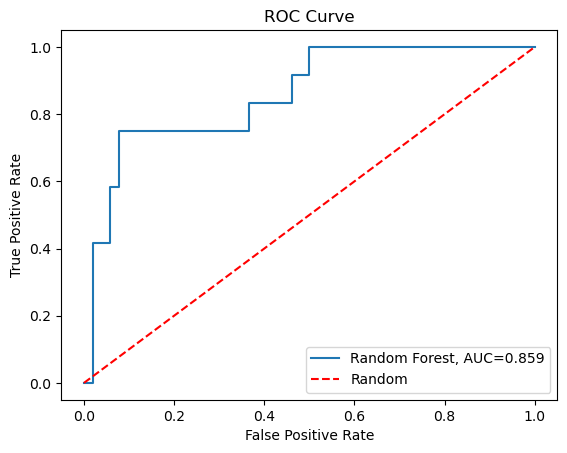

In [231]:
# plot roc curve
plt.plot(rf_fpr, rf_tpr, label='Random Forest, AUC='+str(round(rf_auc, 3)))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Logistic Regression

In [232]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

In [233]:
# assign model and class probabilites
log_reg = LogisticRegression(random_state=16)
cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
log_reg_probs = cross_val_predict(log_reg, X, y_binary, cv=cv, method='predict_proba')

# keep only positive class probabilities
log_reg_probs = log_reg_probs[:, 1]

# calculate FPR and TPR
lr_fpr, lr_tpr, _ = roc_curve(y_binary, log_reg_probs)
lr_auc = auc(lr_fpr, lr_tpr)
print(lr_auc)

0.8990384615384616


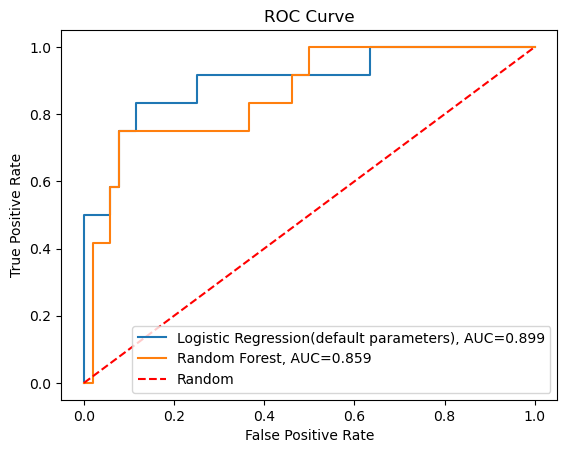

In [234]:
# plot roc curve
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression(default parameters), AUC='+str(round(lr_auc, 3)))
plt.plot(rf_fpr, rf_tpr, label='Random Forest, AUC='+str(round(rf_auc, 3)))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## nested cv L2

In [235]:
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
import numpy as np
from sklearn.metrics import auc

In [236]:
# assign fold for CV
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)          
c_values = [0.001, 0.01, 0.1, 1]

history=[]

pointer = 1

# for each outer fold, print the best C value and training/test AUC
for train_index, test_index in cv.split(X, y):                          
    print('\nNestedCV: {} of outer fold {}'.format(pointer, cv.get_n_splits()))
    x_train, x_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    model = LogisticRegressionCV(Cs = c_values, scoring='roc_auc', cv=cv)     
    model.fit(x_train, y_train.values.ravel())

    pred_test = model.predict_proba(x_test)
    pred_training = model.predict_proba(x_train)
    
    auc_train = roc_auc_score(y_train, pred_training[:, 1])                   
    auc_test = roc_auc_score(y_test, pred_test[:, 1])
    
    print("""
    C value: {}
    
    Training
        AUC: {}
    Test
        AUC: {}
  
    """.format(
        model.C_,
        auc_train,
        auc_test,
        )
    )
    history.append(auc_test)
    pointer += 1
    
print('Overall test performance: {:.2f}'.format(np.mean(history)))


NestedCV: 1 of outer fold 10

    C value: [0.1]
    
    Training
        AUC: 1.0
    Test
        AUC: 0.9
  
    

NestedCV: 2 of outer fold 10

    C value: [0.001]
    
    Training
        AUC: 0.9680851063829787
    Test
        AUC: 0.9
  
    

NestedCV: 3 of outer fold 10

    C value: [0.01]
    
    Training
        AUC: 1.0
    Test
        AUC: 1.0
  
    

NestedCV: 4 of outer fold 10

    C value: [0.01]
    
    Training
        AUC: 1.0
    Test
        AUC: 0.33333333333333337
  
    

NestedCV: 5 of outer fold 10

    C value: [0.1]
    
    Training
        AUC: 1.0
    Test
        AUC: 1.0
  
    

NestedCV: 6 of outer fold 10

    C value: [0.01]
    
    Training
        AUC: 1.0
    Test
        AUC: 1.0
  
    

NestedCV: 7 of outer fold 10

    C value: [0.1]
    
    Training
        AUC: 1.0
    Test
        AUC: 1.0
  
    

NestedCV: 8 of outer fold 10

    C value: [0.001]
    
    Training
        AUC: 0.9729206963249516
    Test
        AUC: 1.0
  


In [238]:
# run nested cross validation
model = LogisticRegressionCV(Cs = c_values, scoring='roc_auc', cv=cv)  

probs = cross_val_predict(model, X, y.values.ravel(), cv=cv, method='predict_proba')

# keep only positive class probabilities
probs = probs[:, 1]

cv_fpr, cv_tpr, _ = roc_curve(y, probs, pos_label='Positive')
cv_auc = auc(cv_fpr, cv_tpr)
print(cv_auc)

0.842948717948718


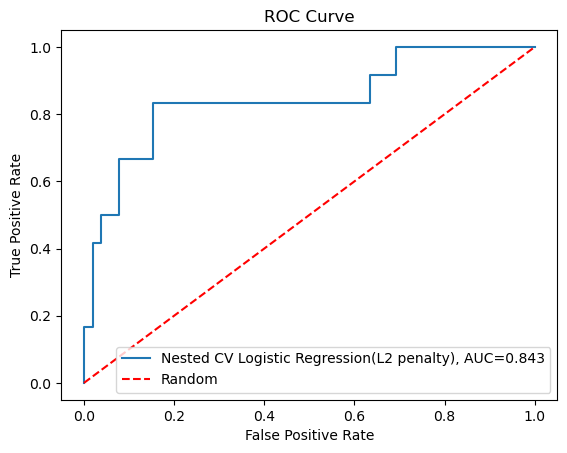

In [239]:
# plot roc curve
plt.plot(cv_fpr, cv_tpr, label='Nested CV Logistic Regression(L2 penalty), AUC='+str(round(cv_auc, 3)))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## nested cv- L1

In [240]:
# assign folds for CV
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)          
c_values = [0.001, 0.01, 0.1, 1]

history=[]

pointer = 1
# for each outer fold, print best C value and training/test AUC
for train_index, test_index in cv.split(X, y):                          
    print('\nNestedCV: {} of outer fold {}'.format(pointer, cv.get_n_splits()))
    x_train, x_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    model = LogisticRegressionCV(Cs = c_values, scoring='roc_auc', cv=cv, penalty='l1', solver='liblinear')     
    model.fit(x_train, y_train.values.ravel())

    pred_test = model.predict_proba(x_test)
    pred_training = model.predict_proba(x_train)
    
    auc_train = roc_auc_score(y_train, pred_training[:, 1])                   
    auc_test = roc_auc_score(y_test, pred_test[:, 1])
    
    print("""
    C value: {}
    
    Training
        AUC: {}
    Test
        AUC: {}
  
    """.format(
        model.C_,
        auc_train,
        auc_test,
        )
    )
    history.append(auc_test)
    pointer += 1
    
print('Overall test performance: {:.2f}'.format(np.mean(history)))


NestedCV: 1 of outer fold 10

    C value: [1.]
    
    Training
        AUC: 1.0
    Test
        AUC: 0.9
  
    

NestedCV: 2 of outer fold 10

    C value: [1.]
    
    Training
        AUC: 1.0
    Test
        AUC: 1.0
  
    

NestedCV: 3 of outer fold 10

    C value: [1.]
    
    Training
        AUC: 1.0
    Test
        AUC: 1.0
  
    

NestedCV: 4 of outer fold 10

    C value: [0.1]
    
    Training
        AUC: 0.9486166007905138
    Test
        AUC: 0.5
  
    

NestedCV: 5 of outer fold 10

    C value: [1.]
    
    Training
        AUC: 1.0
    Test
        AUC: 1.0
  
    

NestedCV: 6 of outer fold 10

    C value: [1.]
    
    Training
        AUC: 1.0
    Test
        AUC: 1.0
  
    

NestedCV: 7 of outer fold 10

    C value: [1.]
    
    Training
        AUC: 1.0
    Test
        AUC: 1.0
  
    

NestedCV: 8 of outer fold 10

    C value: [0.1]
    
    Training
        AUC: 0.8955512572533849
    Test
        AUC: 1.0
  
    

NestedCV: 9 of outer fo

In [241]:
# run cross validation
model = LogisticRegressionCV(Cs = c_values, scoring='roc_auc', cv=cv, penalty='l1', solver='liblinear')  

l1_probs = cross_val_predict(model, X, y.values.ravel(), cv=cv, method='predict_proba')

l1_probs = l1_probs[:, 1]

cv_fpr1, cv_tpr1, _ = roc_curve(y, l1_probs, pos_label='Positive')
cv_auc1 = auc(cv_fpr1, cv_tpr1)
print(cv_auc1)

0.8733974358974359


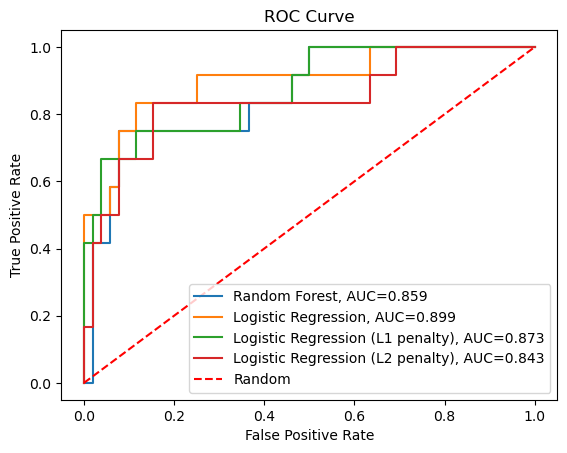

In [242]:
# plot roc curve
plt.plot(rf_fpr, rf_tpr, label='Random Forest, AUC='+str(round(rf_auc, 3)))
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression, AUC='+str(round(lr_auc, 3)))
plt.plot(cv_fpr1, cv_tpr1, label='Logistic Regression (L1 penalty), AUC='+str(round(cv_auc1, 3)))
plt.plot(cv_fpr, cv_tpr, label='Logistic Regression (L2 penalty), AUC='+str(round(cv_auc, 3)))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefig('roc_alldata.png')
plt.show()